In [1]:
from __future__ import print_function

import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Input
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import os
from glob import glob

Using TensorFlow backend.


['fruits_classifier/fruits-360/train\\Apple Braeburn', 'fruits_classifier/fruits-360/train\\Apple Golden 1', 'fruits_classifier/fruits-360/train\\Apple Golden 2', 'fruits_classifier/fruits-360/train\\Apple Golden 3', 'fruits_classifier/fruits-360/train\\Apple Granny Smith']
['fruits_classifier/fruits-360/train\\Apple Braeburn\\0_100.jpg', 'fruits_classifier/fruits-360/train\\Apple Braeburn\\100_100.jpg', 'fruits_classifier/fruits-360/train\\Apple Braeburn\\101_100.jpg', 'fruits_classifier/fruits-360/train\\Apple Braeburn\\102_100.jpg', 'fruits_classifier/fruits-360/train\\Apple Braeburn\\103_100.jpg']
41322
13877


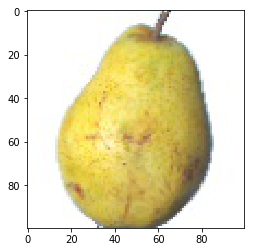

In [2]:
#Data Information and Prep

train_path = 'fruits_classifier/fruits-360/train'
valid_path = 'fruits_classifier/fruits-360/validation'

#Image Information
num_classes = 81
img_rows, img_cols = 100, 100
image_size = [100,100]
folders = glob(train_path + '/*') #returns a list with the folder names. These names are the names of the different classes *this way we can find the number of classes we have
#folders= no_classes
print(folders[0:5])

#Training Information
batch_size = 32
epochs = 50

#glob returns a list with the file names(their path too) present on the path * this(*) can be used in order to extract the number of training examples
image_file_names = glob(train_path + '/*/*.jp*g') #*works like an autocomplete first one is for the class name second is for the picture names and the third is in order to extract both jpg and jpeg
valid_image_file_names = glob(valid_path + "/*/*.jp*g")

print(image_file_names[0:5]) #they contain the whole file path until the image
print(len(image_file_names)) #no training examples
print(len(valid_image_file_names)) #no testing examples

#show an image
plt.imshow(image.load_img(np.random.choice(image_file_names)))
plt.show()


In [3]:
#Data Augmentation

# gen is like a class 
gen = ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=False,
  #rescale=1./255, NEVER RESCALE WITH VGG PREPROCESS
  preprocessing_function=preprocess_input,  
  fill_mode = 'nearest')         # uses the fill mode nearest to fill gaps created by the above


# gen is like a class 
gen_test = ImageDataGenerator(
  #rescale=1./255, NEVER RESCALE WITH VGG PREPROCESS
  preprocessing_function=preprocess_input) 

In [4]:
# get label mapping for confusion matrix plot later 
test_gen = gen_test.flow_from_directory(train_path, target_size=image_size)  #we define the directory where it will extract its data 
print(test_gen.class_indices) #returns the class labels and their corresponding number

labels = [None] * len(test_gen.class_indices)  #[1]*2 -->[1 1] same happens for None
print(len(labels))
for k, v in test_gen.class_indices.items():  #items --> (class name, class number)
  labels[v] = k #we input the number in labels and get the output

Found 41322 images belonging to 81 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Cantaloupe 1': 16, 'Cantaloupe 2': 17, 'Carambula': 18, 'Cherry 1': 19, 'Cherry 2': 20, 'Cherry Rainier': 21, 'Cherry Wax Black': 22, 'Cherry Wax Red': 23, 'Cherry Wax Yellow': 24, 'Clementine': 25, 'Cocos': 26, 'Dates': 27, 'Granadilla': 28, 'Grape Pink': 29, 'Grape White': 30, 'Grape White 2': 31, 'Grapefruit Pink': 32, 'Grapefruit White': 33, 'Guava': 34, 'Huckleberry': 35, 'Kaki': 36, 'Kiwi': 37, 'Kumquats': 38, 'Lemon': 39, 'Lemon Meyer': 40, 'Limes': 41, 'Lychee': 42, 'Mandarine': 43, 'Mango': 44, 'Maracuja': 45, 'Melon Piel de Sapo': 46, 'Mulberry': 47, 'Nectarine': 48, 'Orange': 49, 'Papaya': 50, 'Passion Fruit': 51, 'Peach'

In [5]:
print(test_gen.class_indices) #class_indices is a dictionary, contains the class names and their numbers(encoding)
print(test_gen.class_indices.items())#items --> (class name, class number) tupple
#print(test_gen.class_indices.items()[0]) error #need to be extracted with for like the labels above
print(type(test_gen.class_indices))
print(type(test_gen.class_indices.items()))

{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Cantaloupe 1': 16, 'Cantaloupe 2': 17, 'Carambula': 18, 'Cherry 1': 19, 'Cherry 2': 20, 'Cherry Rainier': 21, 'Cherry Wax Black': 22, 'Cherry Wax Red': 23, 'Cherry Wax Yellow': 24, 'Clementine': 25, 'Cocos': 26, 'Dates': 27, 'Granadilla': 28, 'Grape Pink': 29, 'Grape White': 30, 'Grape White 2': 31, 'Grapefruit Pink': 32, 'Grapefruit White': 33, 'Guava': 34, 'Huckleberry': 35, 'Kaki': 36, 'Kiwi': 37, 'Kumquats': 38, 'Lemon': 39, 'Lemon Meyer': 40, 'Limes': 41, 'Lychee': 42, 'Mandarine': 43, 'Mango': 44, 'Maracuja': 45, 'Melon Piel de Sapo': 46, 'Mulberry': 47, 'Nectarine': 48, 'Orange': 49, 'Papaya': 50, 'Passion Fruit': 51, 'Peach': 52, 'Peach Flat': 53, 'Pear': 54, 'Pear Ab

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 100, 100, 3)
(32, 81)
(100, 100, 3)
min: -96.939 max: 151.061


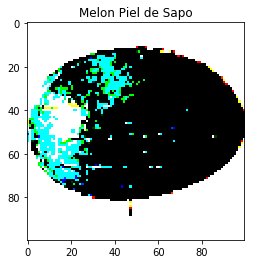

In [6]:
for x, y in test_gen: #test_gen returns tupples x--> input data y-->label it is a generator
  print(x.shape)  #tr examples=batch size, height,width, channels
  print(y.shape)  # one hot encoding 81 = no classes
  print(x[0].shape) #one image
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])]) #labels was created by us and it contains the class name in the corresponding position (number)
  plt.imshow(x[0])
  plt.show()
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
(32, 100, 100, 3)
(32, 81)
(100, 100, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


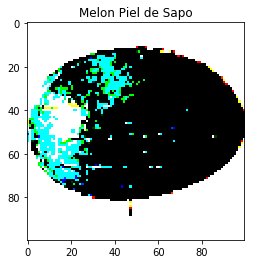

In [7]:
temp2,templabel = test_gen[0]  #test_gen returns a tupple with contains the data and the corresponding label (its number)
print(type(temp2))
print(temp2.shape)
print(templabel.shape) #32 is the default batch size, each time the generator sends a batch of 32(default)
print(temp2[0].shape) #we extract the first photo
print(templabel[0]) #we have one hot encoding
plt.title(labels[np.argmax(templabel[0])]) #labels was created by us and it contains the class name in the corresponding position (number)
plt.imshow(temp2[0])
plt.show()

In [8]:
#We create the generators that will be used to data augment and preprocess our data

train_generator = gen.flow_from_directory( # It should contain one subdirectory per class  the labels for each data are created from the subfolder name
  train_path, #it will extract all the data from here, doesnt matter if they are inside the folders 
  target_size=image_size, #height width
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=image_size, #height width
  shuffle=True,
  batch_size=batch_size,
)

Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


In [9]:
#Neural Network Architecture

vgg = VGG16(input_shape = image_size +[3], weights = "imagenet", include_top = False) #weights initialized on imagenet, the 2fc layers and the softmax layer are dropped 

vgg.summary()#check the  trainable parameters at the bottom    

for layer in vgg.layers:
    layer.trainable = False #we define all the previous layers as non trainable

vgg.summary() #check the non trainable parameters at the bottom     

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [10]:
print(vgg.output.shape) #(?, 1, 1, 512)
no_classes = num_classes #or len(folders)

#Flattening
x = Flatten()(vgg.output) #output needs to be flattened in order to be fed at the fc layers, output dimensions are mentioned above

#Fully Connected Layers
x = Dense(units=2048)(x) #128 neurons
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)#Dropout probability to drop a neuron #Dropout is added after the activation
x = Dense(units=2048)(x) #128 neurons
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)#Dropout probability to drop a neuron #Dropout is added after the activation
x = Dense(units=no_classes)(x)#Where k is the no classes


prediction = Activation('softmax')(x) #Here on the contrary with tensorflow we have to manually add the softmax layer

(?, 3, 3, 512)


In [11]:
#We initialize our keras model (functional api)

model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [12]:
#We initialize our callbacks

checkpoint = ModelCheckpoint("fruits_vgg16_checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

#reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
#                              factor = 0.2,
#                              patience = 3,
#                              verbose = 1,
#                              min_delta = 0.0001)

# we put our call backs into a callback list
#callbacks = [earlystop, checkpoint, reduce_lr]
callbacks = [earlystop, checkpoint]



In [13]:
#We compile our model
adam = Adam(lr=0.001) #default is 0.001

model.compile(loss ='categorical_crossentropy', #needs one hot encoding
             optimizer = adam,
             metrics = ["accuracy"])

In [14]:
#fit  #keras has a special fit function that takes as an input the generators
 
epochs = 20
    
r = model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs,
                        steps_per_epoch = len(image_file_names)//batch_size, #// rounds the result
                        validation_steps = len(valid_image_file_names)//batch_size,
                        callbacks = callbacks, verbose = 2 # 1 bugged the system
                       )
# r contains the results not the model itself

Epoch 1/20
 - 147s - loss: 0.3212 - acc: 0.9096 - val_loss: 0.1628 - val_acc: 0.9558

Epoch 00001: val_loss improved from inf to 0.16278, saving model to fruits_vgg16_checkpoint.h5
Epoch 2/20
 - 151s - loss: 0.1230 - acc: 0.9598 - val_loss: 0.1187 - val_acc: 0.9642

Epoch 00002: val_loss improved from 0.16278 to 0.11869, saving model to fruits_vgg16_checkpoint.h5
Epoch 3/20
 - 141s - loss: 0.0964 - acc: 0.9692 - val_loss: 0.1151 - val_acc: 0.9653

Epoch 00003: val_loss improved from 0.11869 to 0.11509, saving model to fruits_vgg16_checkpoint.h5
Epoch 4/20
 - 142s - loss: 0.0842 - acc: 0.9725 - val_loss: 0.1020 - val_acc: 0.9688

Epoch 00004: val_loss improved from 0.11509 to 0.10204, saving model to fruits_vgg16_checkpoint.h5
Epoch 5/20
 - 143s - loss: 0.0725 - acc: 0.9768 - val_loss: 0.0984 - val_acc: 0.9736

Epoch 00005: val_loss improved from 0.10204 to 0.09843, saving model to fruits_vgg16_checkpoint.h5
Epoch 6/20
 - 140s - loss: 0.0595 - acc: 0.9800 - val_loss: 0.0785 - val_acc: 0

In [15]:
#Model saving for safety

model.save("vgg16_fruits360_safe1.h5")
print("Model Saved")

Model Saved


In [16]:
#We decrease the learning rate

adam = Adam(lr=0.0001) #default is 0.001

model.compile(loss ='categorical_crossentropy', #needs one hot encoding
             optimizer = adam,
             metrics = ["accuracy"])

In [17]:
#fit  #keras has a special fit function that takes as an input the generators
 
epochs = 20
    
r1 = model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs,
                        steps_per_epoch = len(image_file_names)//batch_size, #// rounds the result
                        validation_steps = len(valid_image_file_names)//batch_size,
                        callbacks = callbacks, verbose = 2 # 1 bugged the system
                       )
# r contains the results not the model itself

Epoch 1/20
 - 144s - loss: 0.0256 - acc: 0.9889 - val_loss: 0.0652 - val_acc: 0.9796

Epoch 00001: val_loss improved from 0.07848 to 0.06519, saving model to fruits_vgg16_checkpoint.h5
Epoch 2/20
 - 141s - loss: 0.0185 - acc: 0.9911 - val_loss: 0.0603 - val_acc: 0.9777

Epoch 00002: val_loss improved from 0.06519 to 0.06032, saving model to fruits_vgg16_checkpoint.h5
Epoch 3/20
 - 142s - loss: 0.0167 - acc: 0.9923 - val_loss: 0.0531 - val_acc: 0.9788

Epoch 00003: val_loss improved from 0.06032 to 0.05311, saving model to fruits_vgg16_checkpoint.h5
Epoch 4/20
 - 140s - loss: 0.0162 - acc: 0.9924 - val_loss: 0.0557 - val_acc: 0.9776

Epoch 00004: val_loss did not improve from 0.05311
Epoch 5/20
 - 141s - loss: 0.0139 - acc: 0.9927 - val_loss: 0.0603 - val_acc: 0.9776

Epoch 00005: val_loss did not improve from 0.05311
Epoch 6/20
 - 149s - loss: 0.0142 - acc: 0.9934 - val_loss: 0.0788 - val_acc: 0.9729

Epoch 00006: val_loss did not improve from 0.05311
Epoch 7/20
 - 144s - loss: 0.0141 

In [18]:
#Model saving for safety

model.save("vgg16_fruits360_final.h5")
print("Model Saved")

Model Saved


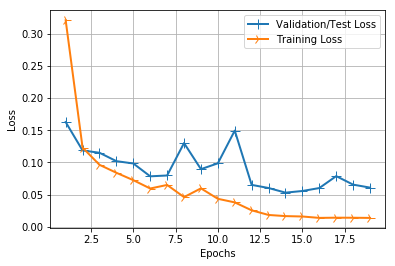

In [31]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict  = r.history
history_dict1 = r1.history

loss_values = history_dict['loss'] + history_dict1['loss'] 
val_loss_values = history_dict['val_loss'] + history_dict1['val_loss'] 
epochs = range(1, 1 + len(loss_values)) 


line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

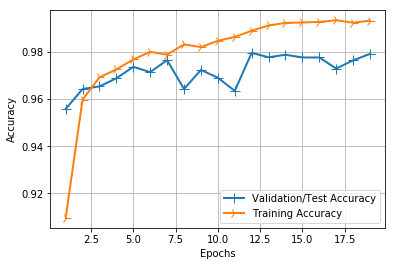

In [32]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = r.history

acc_values = history_dict['acc'] + history_dict1['acc'] 
val_acc_values = history_dict['val_acc'] + history_dict1['val_acc'] 
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
print(" Best train accuracy ",max(history_dict1['acc']),"Best testing accuracy", max(history_dict1['val_acc']) )

 Best train accuracy  0.9933882295955437 Best testing accuracy 0.9795756351039261
